In [1]:
import os
import csv 
import numpy as np
import pandas as pd
from PIL import Image
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
os.chdir('/content/drive/Othercomputers/My MacBook Pro/Program 4')

### Feature extraction 

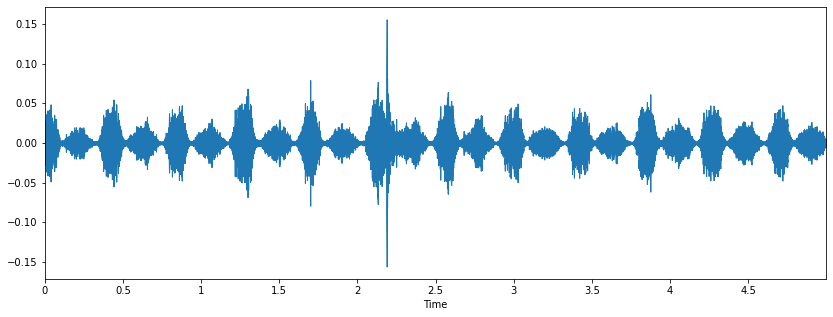

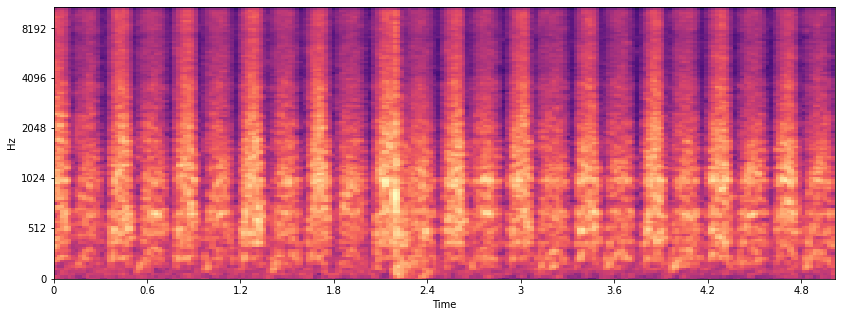

In [3]:
# Get list of audio file paths
audio_data = list()
for sample in os.listdir('dataset'):
    audio_data.append(f'dataset/{sample}')

# Function to display Mel spectrogram
def mel_spectrogram(sample, sr):
    S = librosa.feature.melspectrogram(y=sample, sr=sr)
    melS = librosa.power_to_db(S=S, ref=np.max)
    return librosa.display.specshow(melS, sr=sample_rate, x_axis='time', y_axis='mel')

# Examine single audio sample & display waveform
sample, sample_rate = librosa.load(audio_data[0])
plt.figure(figsize=(14, 5))
librosa.display.waveplot(sample, sr=sample_rate)
plt.figure(figsize=(14, 5))
mel_spectrogram(sample, sample_rate)

**Uncomment to run this section once to convert .wav to .jpg**

In [ ]:
# # Function to extract features
# def extract_audio_features(filename):
#     # Load audio file as floating point time series
#     x, sr = librosa.load(filename)
#     # Extract Mel-frequency cepstral coefficient features
#     return mel_spectrogram(x, sr)

# # Save raw audio files to as spectrogram image file
# for file in audio_data:
#     img_file = file.lstrip('dataset/').replace('.wav', '.jpg')
#     extract_audio_features(file)
#     plt.savefig(f'spectrogram/{img_file}')

### Load spectrogram images 

In [4]:
# Load spectrogram images into numpy array
audio_images = []
# Load in sequential order
for i in range(1, 672):
    img = Image.open(f'spectrogram/{i}.jpg')
    if img is not None:
        audio_images.append(np.array(img))

X = np.array(audio_images)
X.shape

(671, 288, 432, 3)

### Build autoencoder 

In [14]:
IMG_SIZE = X.shape[1:]
ENCODE_DIMS = 20
np.random.seed(5)

# Extract feature maps (encoded representation of spectrogram)
input = Input(IMG_SIZE)
x = Conv2D(filters=128, kernel_size=(3, 3), input_shape=IMG_SIZE, activation='relu', padding='same')(input)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
encoder = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

# Reconstruct feature map
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(encoder)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
decoder = Conv2D(filters=3, kernel_size=(3, 3), activation='relu', padding='same')(x)

# Build autoencoder model
autoencoder = Model(input, decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 288, 432, 3)]     0         
                                                                 
 conv2d_27 (Conv2D)          (None, 288, 432, 128)     3584      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 144, 216, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 144, 216, 128)     147584    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 72, 108, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 72, 108, 64)       7379

### Pre-train autoencoder 

Epoch 1/100
168/168 [==============================] - 11s 60ms/step - loss: 3468.1453
Epoch 2/100
168/168 [==============================] - 10s 60ms/step - loss: 518.1031
Epoch 3/100
168/168 [==============================] - 10s 60ms/step - loss: 436.7784
Epoch 4/100
168/168 [==============================] - 10s 60ms/step - loss: 401.5301
Epoch 5/100
168/168 [==============================] - 10s 60ms/step - loss: 399.6346
Epoch 6/100
168/168 [==============================] - 10s 60ms/step - loss: 357.2820
Epoch 7/100
168/168 [==============================] - 10s 61ms/step - loss: 336.6729
Epoch 8/100
168/168 [==============================] - 10s 58ms/step - loss: 359.0768
Epoch 9/100
168/168 [==============================] - 10s 58ms/step - loss: 387.1836
Epoch 10/100
168/168 [==============================] - 10s 60ms/step - loss: 304.4192
Epoch 11/100
168/168 [==============================] - 10s 59ms/step - loss: 274.2927
Epoch 12/100
168/168 [=============================

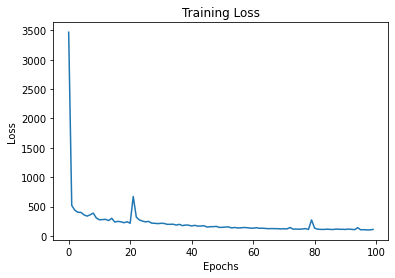

In [15]:
# Monitor training
earlystopping = EarlyStopping(monitor='loss', min_delta=0.05, patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_weights.hdf5', monitor='loss', save_best_only=True)
# Train model
history = autoencoder.fit(X, X, 
                          batch_size=4, 
                          epochs=100, 
                          callbacks=[earlystopping, checkpoint])
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

### Make predictions with encoder

In [16]:
# Load saved model from training
autoencoder.load_weights('best_weights.hdf5')
# Build encoder model to extract deep features using best weights from pre-trained autoencoder
_encoder = Model(input, encoder)
# Load weights from autoencoder into encoder
for i in range(0, len(_encoder.layers)):
    weights = autoencoder.layers[i].get_weights()
    _encoder.layers[i].set_weights(weights)


# Predict with encoder
pred = _encoder.predict(X)
# Reshape predictions to feed into K-means
pred = pred.reshape((pred.shape[0], (pred.shape[1]*pred.shape[2]*pred.shape[3])))

### Perform clustering via K-means

In [17]:
categories = np.arange(1, 21)
kmeans = KMeans(n_clusters=len(categories))
kmeans.fit(pred)
clusters = kmeans.labels_ + 1

### Store predictions in text file

In [18]:
with open(f'predictions.txt', 'w') as text_file:
    for cluster in clusters:
        text_file.write(f'{cluster}\n')
